In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# --- Configuration for your dataset and model ---
# Image dimensions
IMG_WIDTH = 150
IMG_HEIGHT = 150

# Batch size for training
# You establish a batch size instead of passing all the files at once. 
BATCH_SIZE = 32

# Number of epochs for training
EPOCHS = 15 #this is one passing of the data or batch through the algorithm

# Paths to your organized data
# This only works if the cats_vs_dogs_data folder is within the same folder ass the ipynb file or the notebook.
base_data_dir = 'cats_vs_dogs_data'

# The statements below simply make a string out of the path. It does not check if they are valid entries
train_dir = os.path.join(base_data_dir, 'train') # This creates a string from the base directory to the train directory
validation_dir = os.path.join(base_data_dir, 'validation') # This can aslo be used with multiple parameters to access grandchildren folders
print(f"Training directory: {train_dir}")
print(f"Validation directory: {validation_dir}")

In [ ]:
if not os.path.exists(train_dir) or not os.path.exists(validation_dir): #Verify if the paths create are actual valid paths and do exist
    print("Error with the training or validation directory paths.")
else:
    try: #this try block is to make sure that the os.path.join() has a valid path to the cats or dogs images
        print(f"Cat images for training: {len(os.listdir(os.path.join(train_dir, 'cats')))}") #this finds the length of the values within a given path eg. traindir/cats
        print(f"Dog images for training: {len(os.listdir(os.path.join(train_dir, 'dogs')))}")
        print(f"Cat images for validation: {len(os.listdir(os.path.join(validation_dir, 'cats')))}")
        print(f"Dog images for validation: {len(os.listdir(os.path.join(validation_dir, 'dogs')))}")

    except FileNotFoundError:
        print("ERROR one of the files were not found. Recheck the path for the file or the file image names.")

Cat images for training: 3200
ERROR one of the files were not found. Recheck the path for the file or the file image names.


In [ ]:
# Create training dataset
# image_dataset_from_directory provides a convenient, pre-built function that handles all that image
# loading and initial preprocessing complexity for you, directly creating a tf.data.Dataset object that 
# Keras models can easily consume.
# In this case, the train_data_set is the tf.data.Dataset
# There are also a ton of other data loading utilities to preprocess data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, # The first parameter is always the path to the directory from which we are training from 
    labels='inferred', # Labels can be inferred from the directory structure, No labels at all or list of integers(for multiple classifications) are possible labels
    label_mode='binary', # For cat vs dog (0 or 1), can also be integer based where each integer signals a type
    image_size=(IMG_HEIGHT, IMG_WIDTH), # Image size is based on the values predefined in the variables
    interpolation='nearest', # Estimating pixels of the resized images(bicubic or bilinear is a lot more higher quality)
    batch_size=BATCH_SIZE, # Size of one iteration of training
    shuffle=True # Shuffling the training data so that the algorithm does not find any specific sequence that the files are stored which can affect the training.
)

# Create validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False # No need to shuffle validation data
)
#once the images are preprocessed, the output is the number of files belonging to the inferred classes.

Found 6400 files belonging to 2 classes.
Found 1600 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names
print(f"Class names TensorFlow inferred: {class_names}")
# This will likely be ['cats', 'dogs'] or ['dogs', 'cats'].
# The first name corresponds to label 0, the second to label 1.

specification = train_dataset.element_spec
print(f"Specification of each element: {specification}")
# This can be used to access the specificatino of an element within the dataset object batch
# The first parameter is the specification for the image batch and the second parameter is the specifications for the label batch


Class names TensorFlow inferred: ['cats', 'dogs']
Specification of each element: (TensorSpec(shape=(None, 150, 150, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))


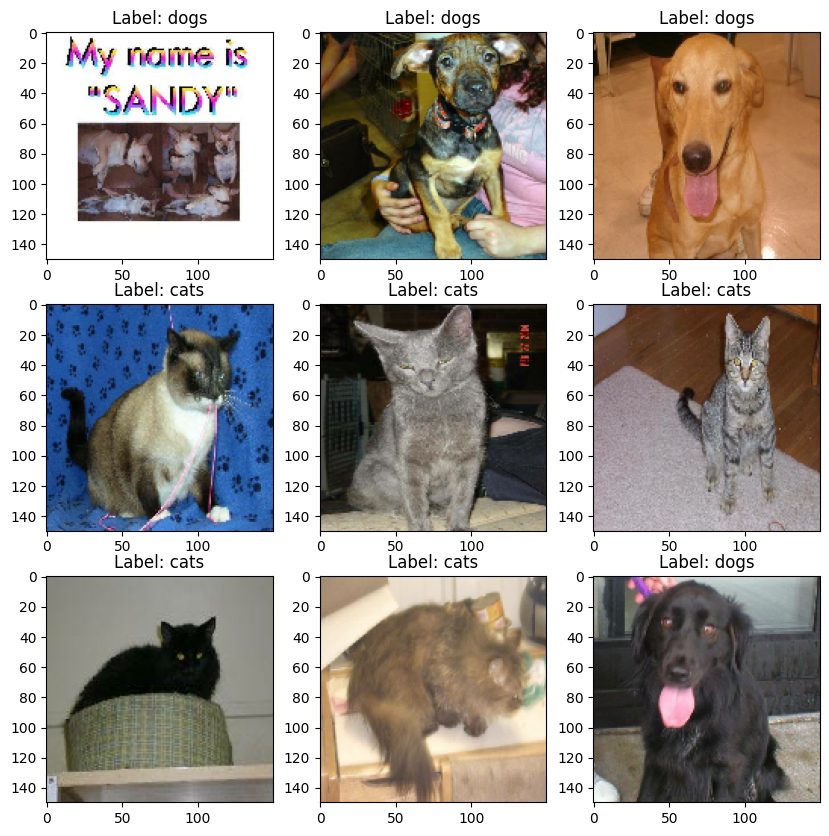

In [ ]:
plt.figure(figsize=(10, 10)) # Creates an area where all plots will be drawn
for images, labels in train_dataset.take(1):  # Takes one batch from the dataset which is 32 images(specified in BATCH_SIZE (also default))
    for i in range(9): # Display the first 9 images in that batch
        if i < len(images): # Make sure we don't go out of bounds if batch is smaller than 9
            ax = plt.subplot(3, 3, i+1) #divides the plot into subplots of a 3x3 grid and variable i goes in each spot of the grid so index 0-8 is grid 1-9 hence i+1
            plt.imshow(images[i].numpy().astype("uint8")) # Convert to NumPy array to a displayable image
            
            # Labels[i] returns an float of the TensorFlow tensor if label_mode = binary
            # We can then convert this using int() then access the correct inferred class_name for us to understand
            plt.title(f"Label: {class_names[int(labels[i])]}")
            plt.axis("off")
plt.show() # This ensures the plot is displayed in the notebook
